# RNN

Here, the dataset is generated using:

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

import numpy as np
import pandas as pd

#Import torch stuff.
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

#pip install git+https://github.com/facebookresearch/WavAugment.git
import augment

import IPython.display as ipd
import matplotlib.pyplot as plt

from tqdm import trange, tqdm

#Append the path outside so we can load bom1.
import sys
sys.path.append('..')

import bom1.wakeword as wf
import bom1.bom1 as bom1
from   bom1.toolbox import WakewordDataset, WakewordDatasetRNN

from sklearn.metrics import accuracy_score

import os

import pickle

In [2]:
#Set the notebook to run on the GPU, if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'This notebook is running on the {device.type}.')

if device.type == 'cuda':
    torch.cuda.current_device()
    torch.cuda.set_device(1)

This notebook is running on the cpu.


In [3]:
folder = '/work3/s164419/01005WakeWordData/RNN_data_10s_shift_5s_1_to_1/train/'
train_dataset = WakewordDatasetRNN(f=T.Spectrogram(hop_length=40), folder=folder, normalize=True, #normalize the audio when reading it with torchaudio. 
                                              transforms = [#wf.AudioAugment(reverb = 100, snr = 15, pitch = 150, p = [0.5, 0.5, 0.5]),
                                              wf.TransformMono(), 
                                              wf.Padder(22050*10)],
                                              target_length = 1375,
                                              ) #sr * length of the clip

folder = '/work3/s164419/01005WakeWordData/RNN_data_10s_shift_5s_1_to_1/val/'
val_dataset = WakewordDatasetRNN(f=T.Spectrogram(hop_length=40), folder=folder, normalize=True, #normalize the audio when reading it with torchaudio. 
                                              transforms = [#wf.AudioAugment(reverb = 100, snr = 15, pitch = 150, p = [0.5, 0.5, 0.5]),
                                              wf.TransformMono(), 
                                              wf.Padder(22050*10)],
                                              target_length = 1375,
                                              ) #sr * length of the clip

#Create the loaders.
if device.type == 'cpu':
    batch_size = 128
else:
    batch_size = 512
    
train_loader  = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader    = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

# Try the RNN

In [4]:
from bom1.models import RNN_V1
rnn = RNN_V1().to(device)
with torch.no_grad():
    rnn.load_state_dict(torch.load('/work3/s164419/01005WakeWordData/models/RNN_V1/upbeat-fire-6_model.pth', map_location=device))

Training data

In [5]:
#Fetch the data
with torch.no_grad():
    x, targets, path = next(iter(train_loader))

    x = x.to(device)

    outputs = rnn(x).squeeze(-1)

contains_catchphrase = targets.any(axis=1)

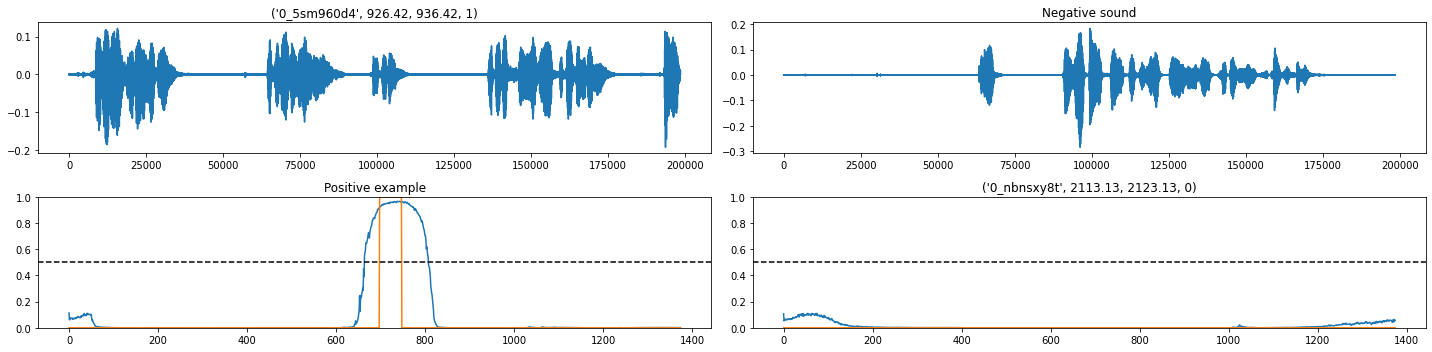

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_5sm960d4/format/url/protocol/https
From 00:15:26.42 to 00:15:36.42
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_nbnsxy8t/format/url/protocol/https
From 00:35:13.13 to 00:35:23.13


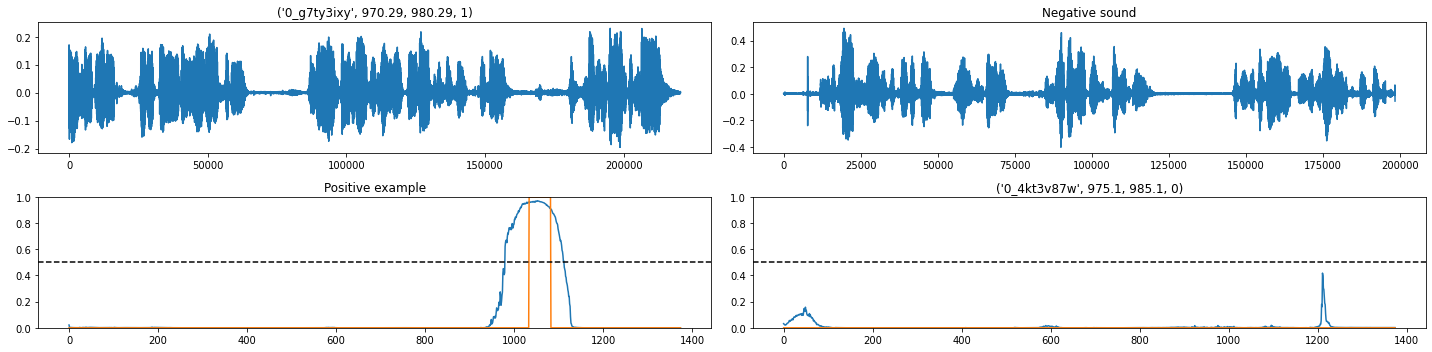

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_g7ty3ixy/format/url/protocol/https
From 00:16:10.29 to 00:16:20.29
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_4kt3v87w/format/url/protocol/https
From 00:16:15.10 to 00:16:25.10


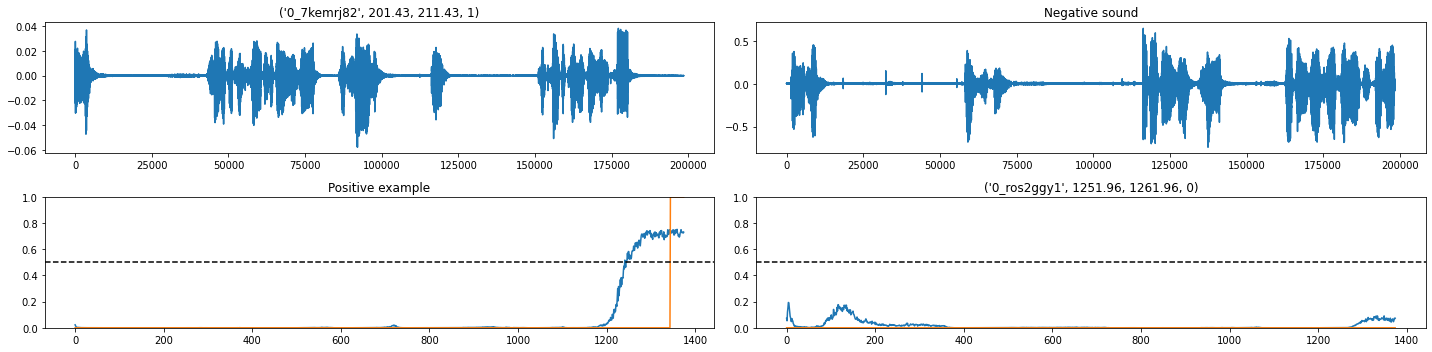

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_7kemrj82/format/url/protocol/https
From 00:03:21.43 to 00:03:31.43
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_ros2ggy1/format/url/protocol/https
From 00:20:51.96 to 00:21:01.96


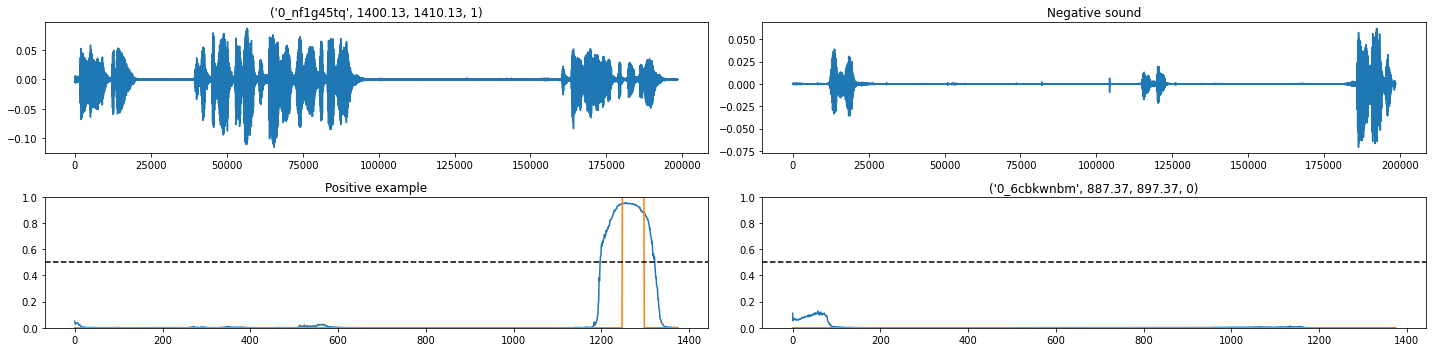

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_nf1g45tq/format/url/protocol/https
From 00:23:20.13 to 00:23:30.13
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_6cbkwnbm/format/url/protocol/https
From 00:14:47.37 to 00:14:57.37


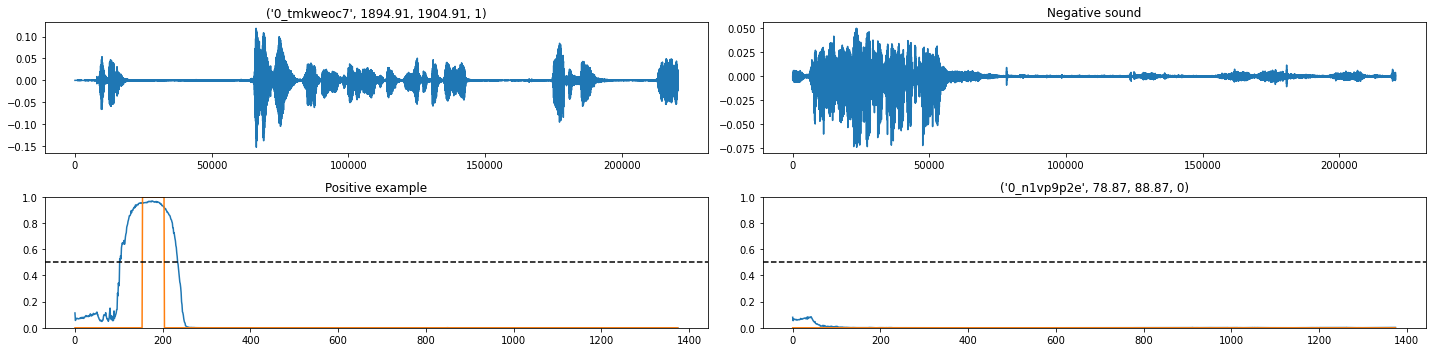

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_tmkweoc7/format/url/protocol/https
From 00:31:34.91 to 00:31:44.91
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_n1vp9p2e/format/url/protocol/https
From 00:01:18.87 to 00:01:28.87


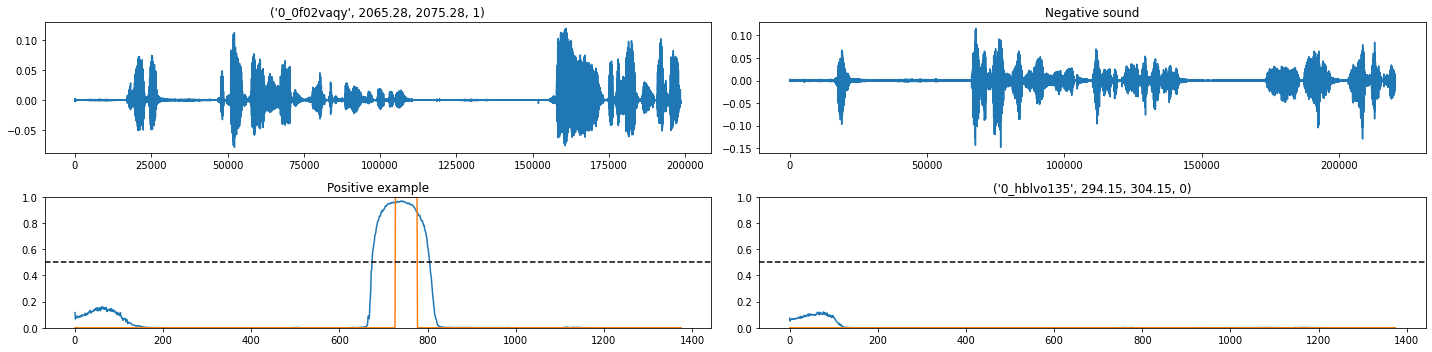

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_0f02vaqy/format/url/protocol/https
From 00:34:25.28 to 00:34:35.28
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_hblvo135/format/url/protocol/https
From 00:04:54.15 to 00:05:04.15


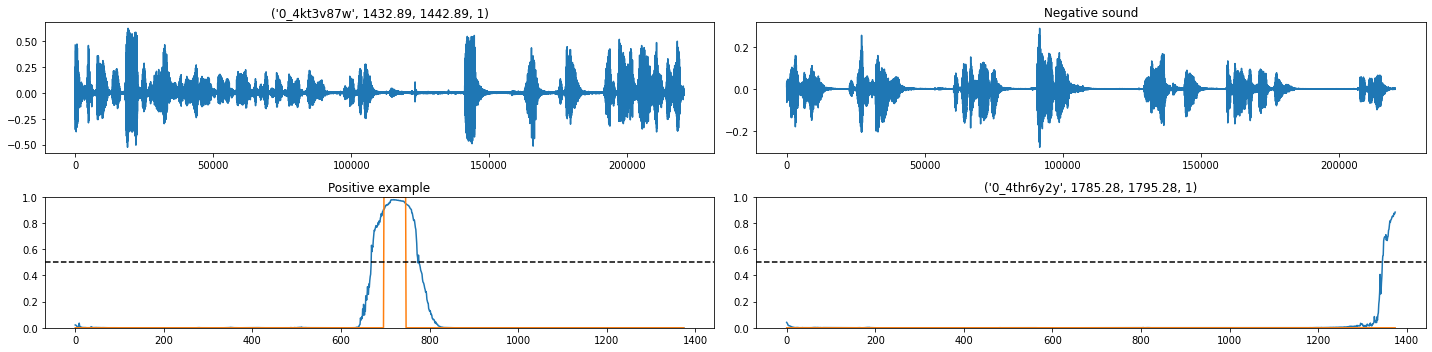

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_4kt3v87w/format/url/protocol/https
From 00:23:52.89 to 00:24:02.89
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_4thr6y2y/format/url/protocol/https
From 00:29:45.28 to 00:29:55.28


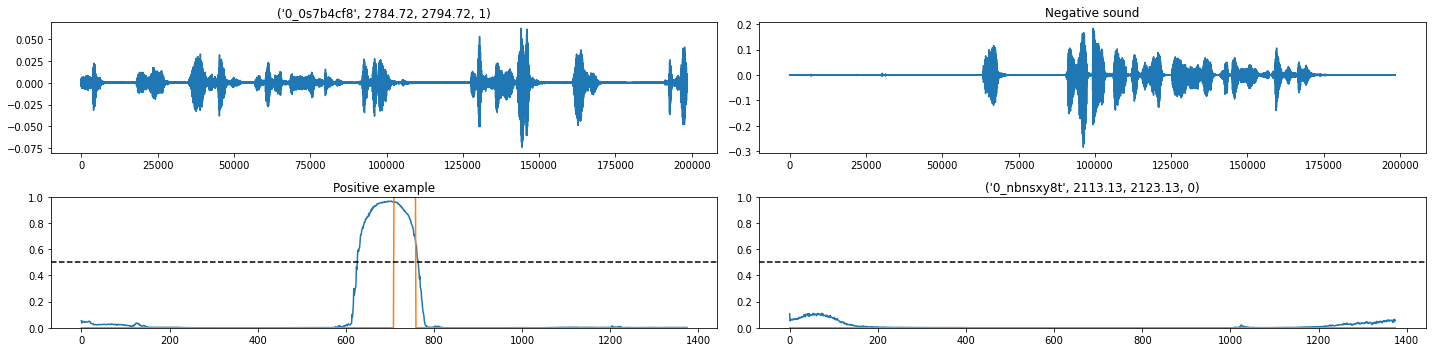

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_0s7b4cf8/format/url/protocol/https
From 00:46:24.72 to 00:46:34.72
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_nbnsxy8t/format/url/protocol/https
From 00:35:13.13 to 00:35:23.13


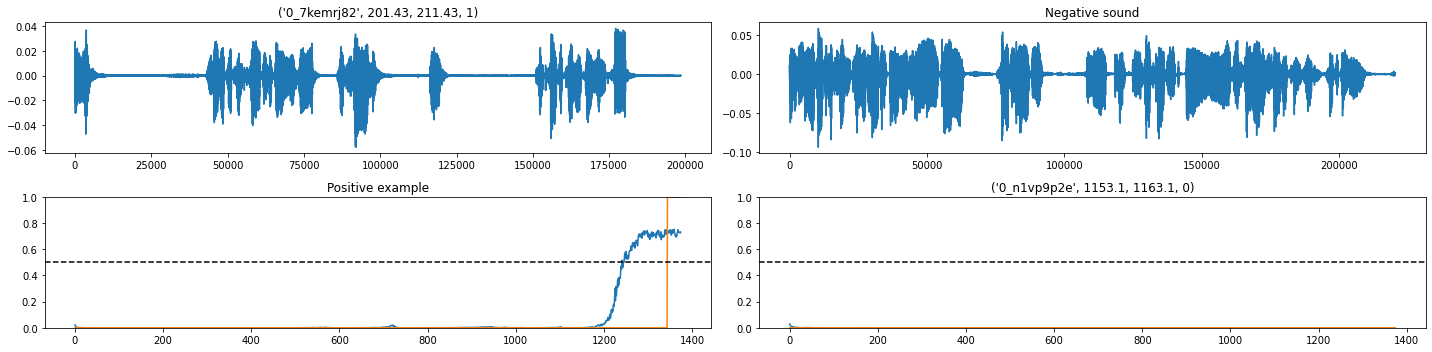

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_7kemrj82/format/url/protocol/https
From 00:03:21.43 to 00:03:31.43
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_n1vp9p2e/format/url/protocol/https
From 00:19:13.10 to 00:19:23.10


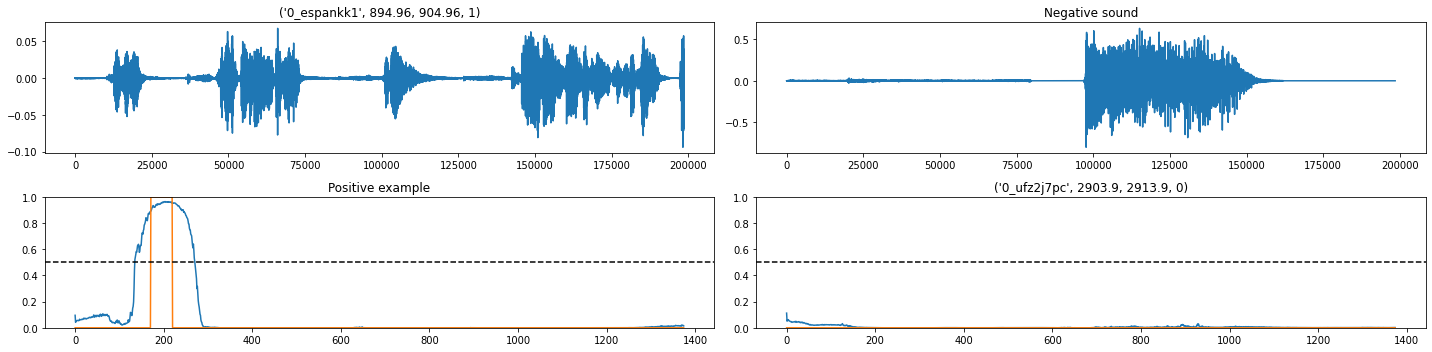

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_espankk1/format/url/protocol/https
From 00:14:54.96 to 00:15:04.96
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_ufz2j7pc/format/url/protocol/https
From 00:48:23.90 to 00:48:33.90


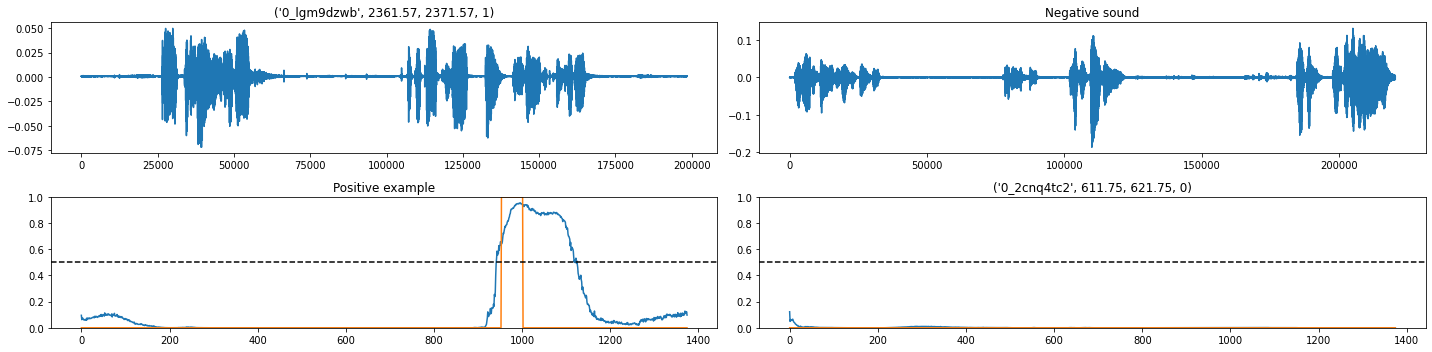

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_lgm9dzwb/format/url/protocol/https
From 00:39:21.57 to 00:39:31.57
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_2cnq4tc2/format/url/protocol/https
From 00:10:11.75 to 00:10:21.75


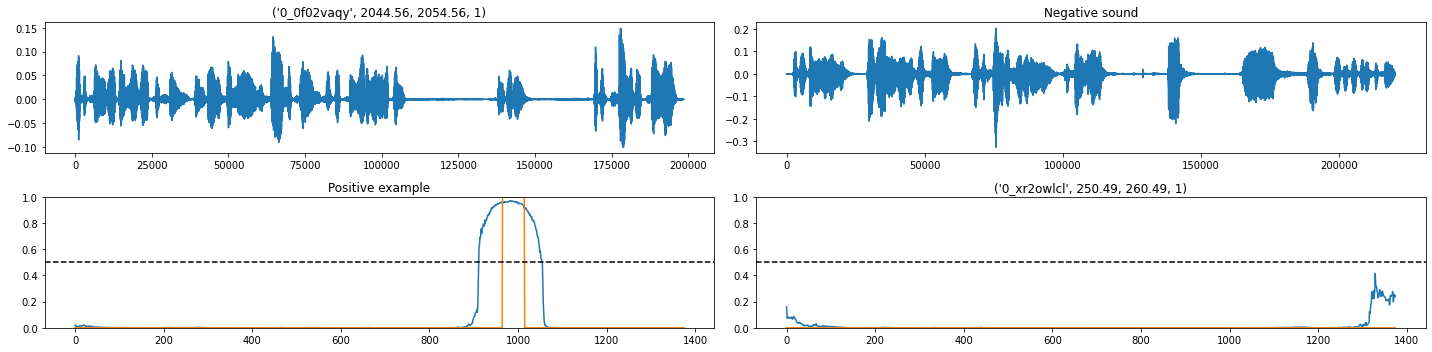

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_0f02vaqy/format/url/protocol/https
From 00:34:04.56 to 00:34:14.56
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_xr2owlcl/format/url/protocol/https
From 00:04:10.49 to 00:04:20.49


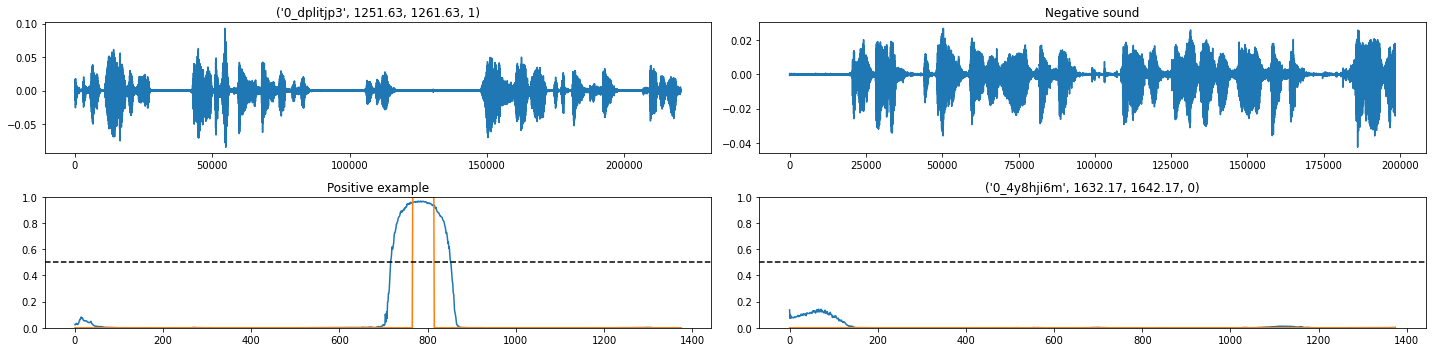

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_dplitjp3/format/url/protocol/https
From 00:20:51.63 to 00:21:01.63
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_4y8hji6m/format/url/protocol/https
From 00:27:12.17 to 00:27:22.17


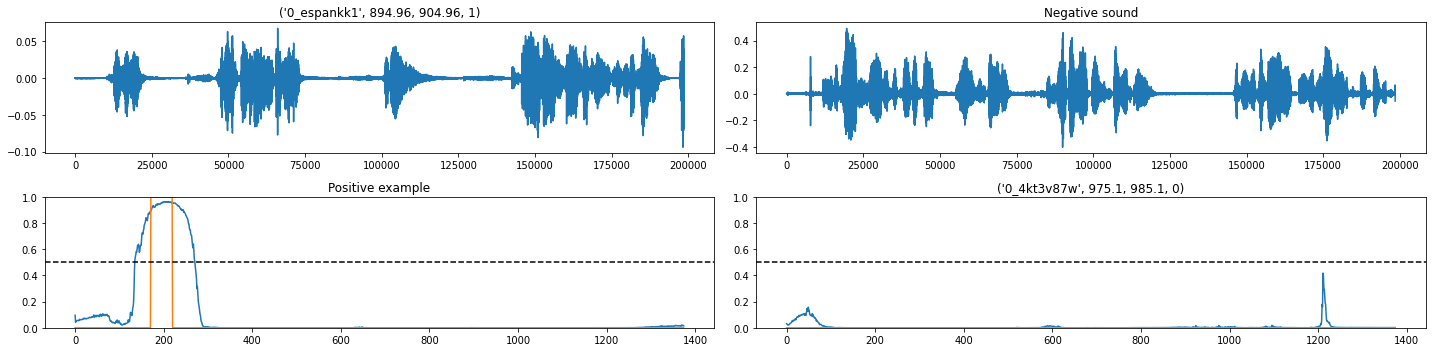

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_espankk1/format/url/protocol/https
From 00:14:54.96 to 00:15:04.96
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_4kt3v87w/format/url/protocol/https
From 00:16:15.10 to 00:16:25.10


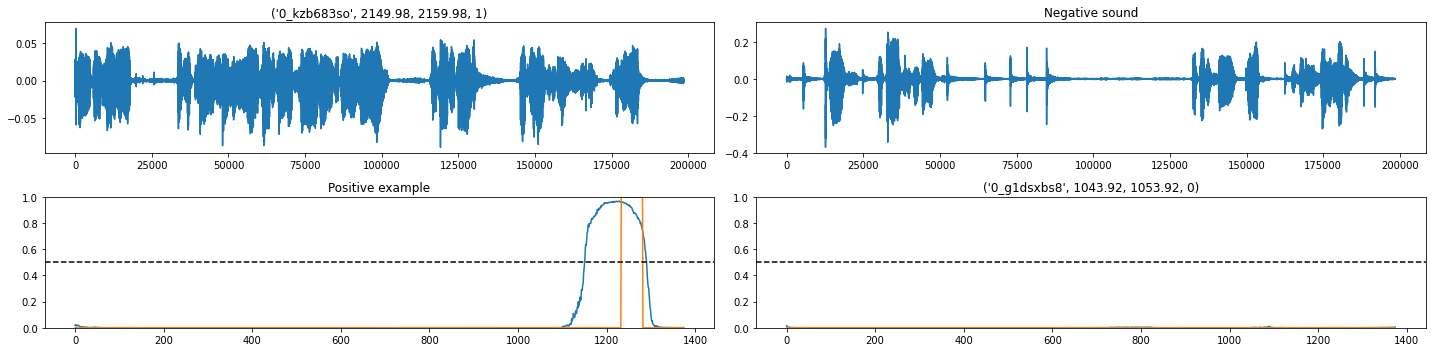

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_kzb683so/format/url/protocol/https
From 00:35:49.98 to 00:35:59.98
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_g1dsxbs8/format/url/protocol/https
From 00:17:23.92 to 00:17:33.92


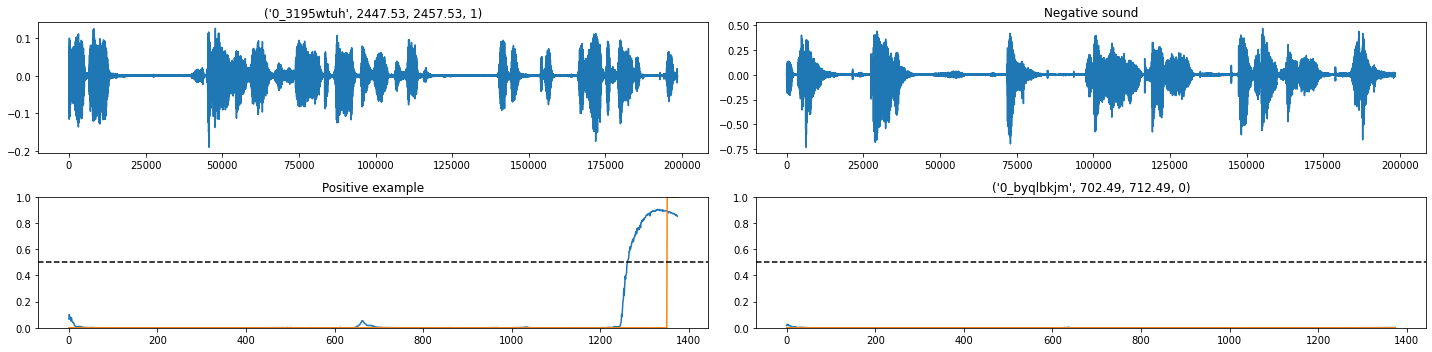

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_3195wtuh/format/url/protocol/https
From 00:40:47.53 to 00:40:57.53
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_byqlbkjm/format/url/protocol/https
From 00:11:42.49 to 00:11:52.49


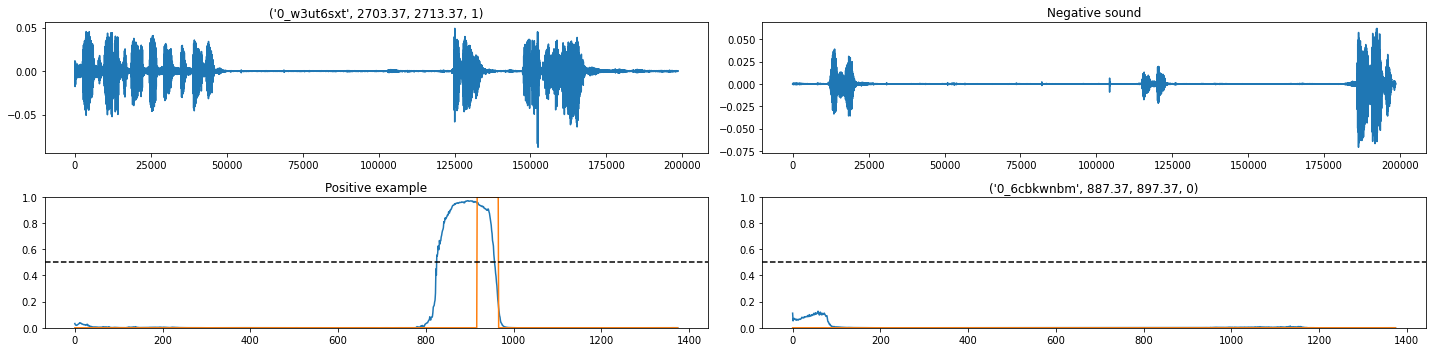

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_w3ut6sxt/format/url/protocol/https
From 00:45:03.37 to 00:45:13.37
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_6cbkwnbm/format/url/protocol/https
From 00:14:47.37 to 00:14:57.37


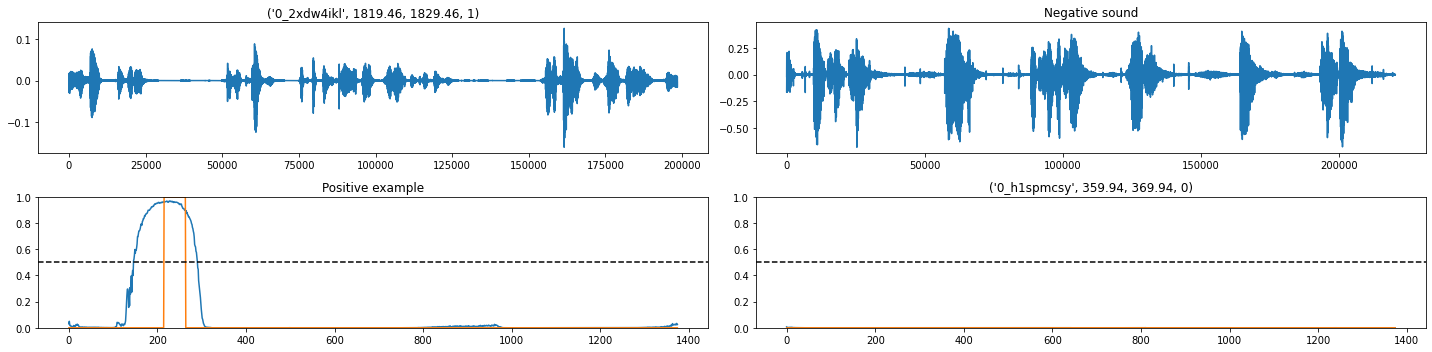

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_2xdw4ikl/format/url/protocol/https
From 00:30:19.46 to 00:30:29.46
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_h1spmcsy/format/url/protocol/https
From 00:05:59.94 to 00:06:09.94


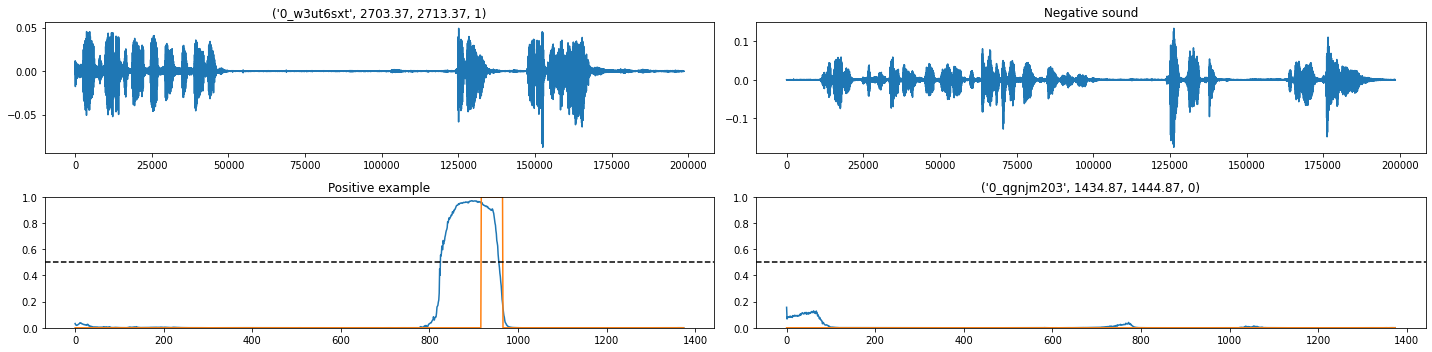

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_w3ut6sxt/format/url/protocol/https
From 00:45:03.37 to 00:45:13.37
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_qgnjm203/format/url/protocol/https
From 00:23:54.87 to 00:24:04.87


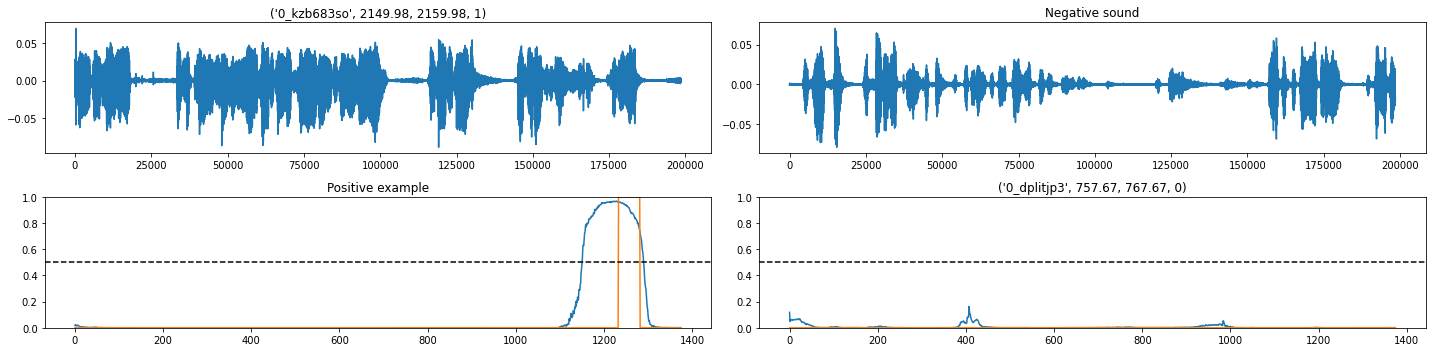

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_kzb683so/format/url/protocol/https
From 00:35:49.98 to 00:35:59.98
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_dplitjp3/format/url/protocol/https
From 00:12:37.67 to 00:12:47.67


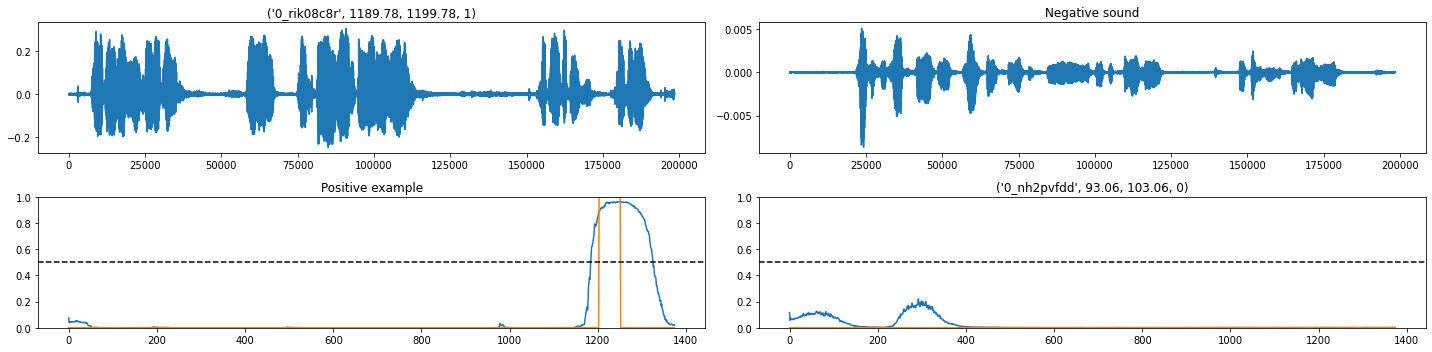

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_rik08c8r/format/url/protocol/https
From 00:19:49.78 to 00:19:59.78
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_nh2pvfdd/format/url/protocol/https
From 00:01:33.06 to 00:01:43.06


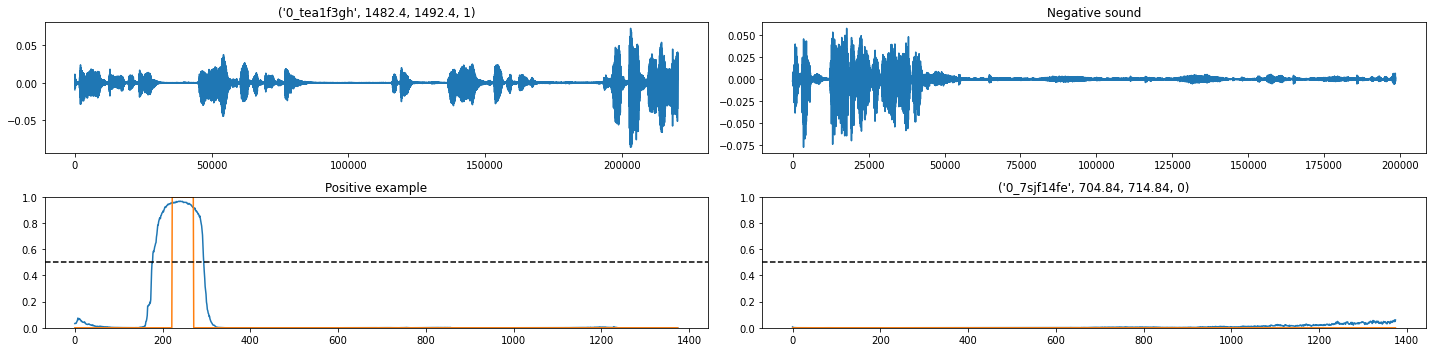

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_tea1f3gh/format/url/protocol/https
From 00:24:42.40 to 00:24:52.40
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_7sjf14fe/format/url/protocol/https
From 00:11:44.84 to 00:11:54.84


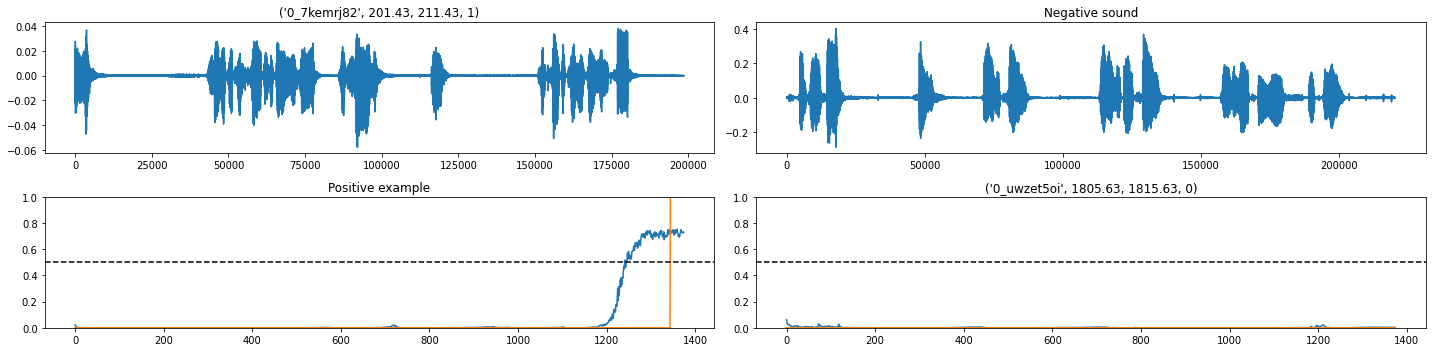

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_7kemrj82/format/url/protocol/https
From 00:03:21.43 to 00:03:31.43
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_uwzet5oi/format/url/protocol/https
From 00:30:05.63 to 00:30:15.63


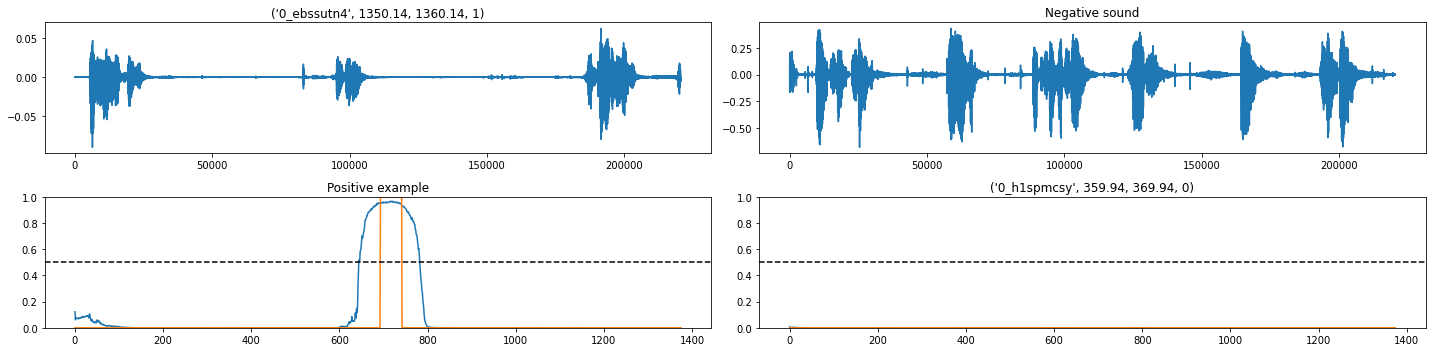

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_ebssutn4/format/url/protocol/https
From 00:22:30.14 to 00:22:40.14
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_h1spmcsy/format/url/protocol/https
From 00:05:59.94 to 00:06:09.94


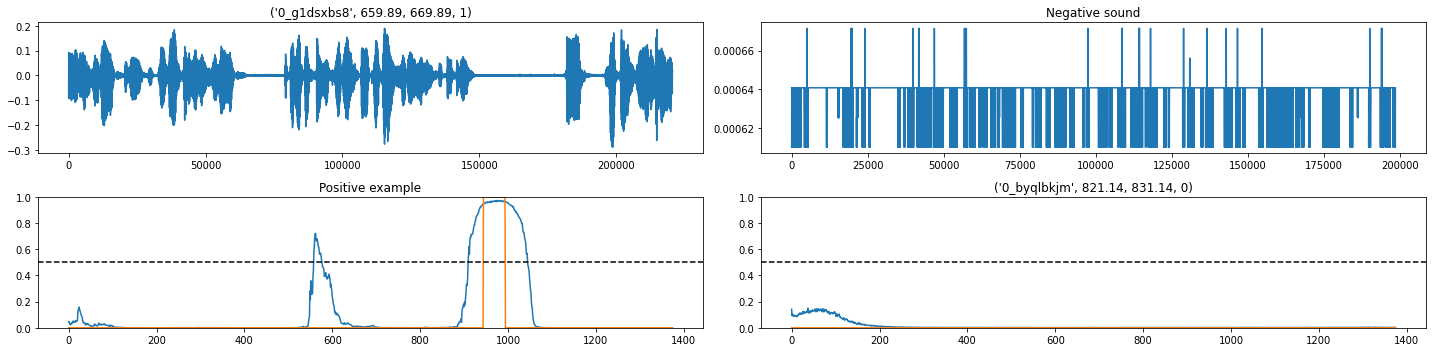

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_g1dsxbs8/format/url/protocol/https
From 00:10:59.89 to 00:11:09.89
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_byqlbkjm/format/url/protocol/https
From 00:13:41.14 to 00:13:51.14


In [6]:
for i in range(25):

    idx_positive = np.random.choice(torch.where(contains_catchphrase)[0])
    idx_negative = np.random.choice(torch.where(contains_catchphrase==0)[0])

    plt.figure(figsize=(20,5))

    plt.subplot(2,2,1)
    audio, sr = torchaudio.load(path[idx_positive])
    plt.plot(audio.mean(axis=0))
    plt.title(wf.info_from_path(path[idx_positive]))

    plt.subplot(2,2,2)
    audio, sr = torchaudio.load(path[idx_negative])
    plt.plot(audio.mean(axis=0))
    plt.title('Negative sound')

    plt.subplot(2,2,3)
    plt.title('Positive example')
    plt.plot(torch.sigmoid(outputs[idx_positive]).detach().cpu())
    plt.plot(targets[idx_positive].detach().cpu())
    plt.axhline(0.5, linestyle='--', color='black')
    plt.ylim([0, 1])

    plt.subplot(2,2,4)
    plt.title(wf.info_from_path(path[idx_negative]))
    plt.plot(torch.sigmoid(outputs[idx_negative]).detach().cpu())
    plt.plot(targets[idx_negative].detach().cpu())
    plt.axhline(0.5, linestyle='--', color='black')
    plt.ylim([0, 1])

    plt.tight_layout()
    plt.show()

    print('Positive example:')
    ID, t1, t2, _ = wf.info_from_path(path[idx_positive])
    print(bom1.stream_link(ID))
    print(f'From {bom1.seconds_to_timestamp(t1)} to {bom1.seconds_to_timestamp(t2)}')

    print('Negative example:')
    ID, t1, t2, _ = wf.info_from_path(path[idx_negative])
    print(bom1.stream_link(ID))
    print(f'From {bom1.seconds_to_timestamp(t1)} to {bom1.seconds_to_timestamp(t2)}')

Test data

In [7]:
#Fetch the data
with torch.no_grad():
    x, targets, path = next(iter(val_loader))

    x = x.to(device)

    outputs = rnn(x).squeeze(-1)

contains_catchphrase = targets.any(axis=1)

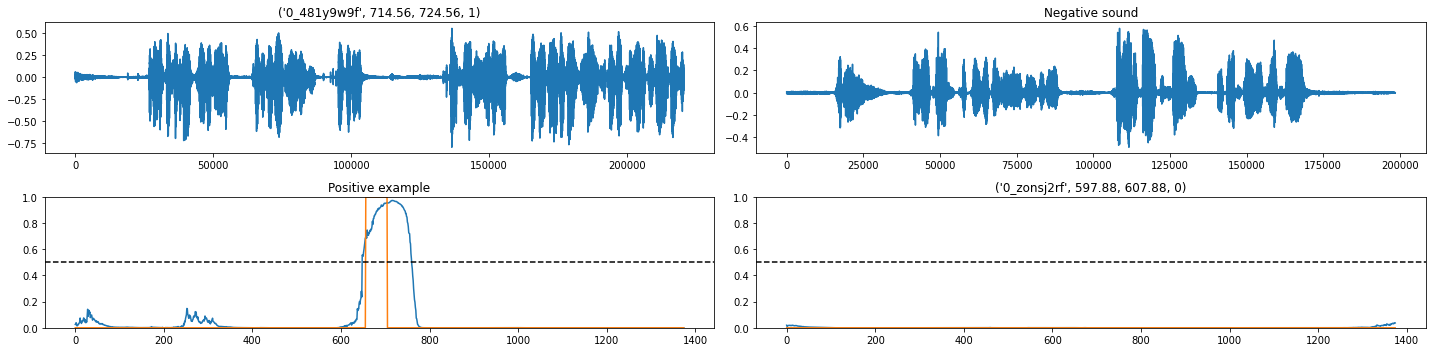

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_481y9w9f/format/url/protocol/https
From 00:11:54.56 to 00:12:04.56
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_zonsj2rf/format/url/protocol/https
From 00:09:57.88 to 00:10:07.88


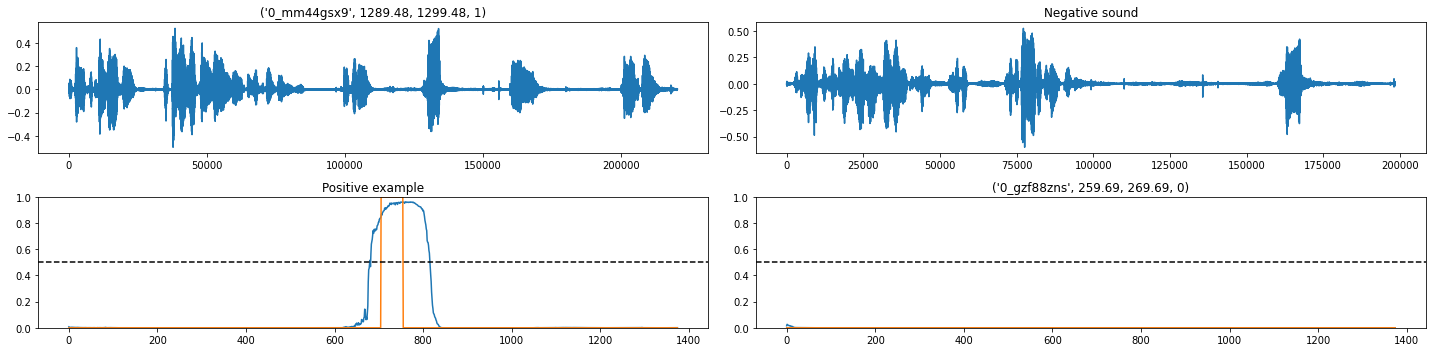

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_mm44gsx9/format/url/protocol/https
From 00:21:29.48 to 00:21:39.48
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_gzf88zns/format/url/protocol/https
From 00:04:19.69 to 00:04:29.69


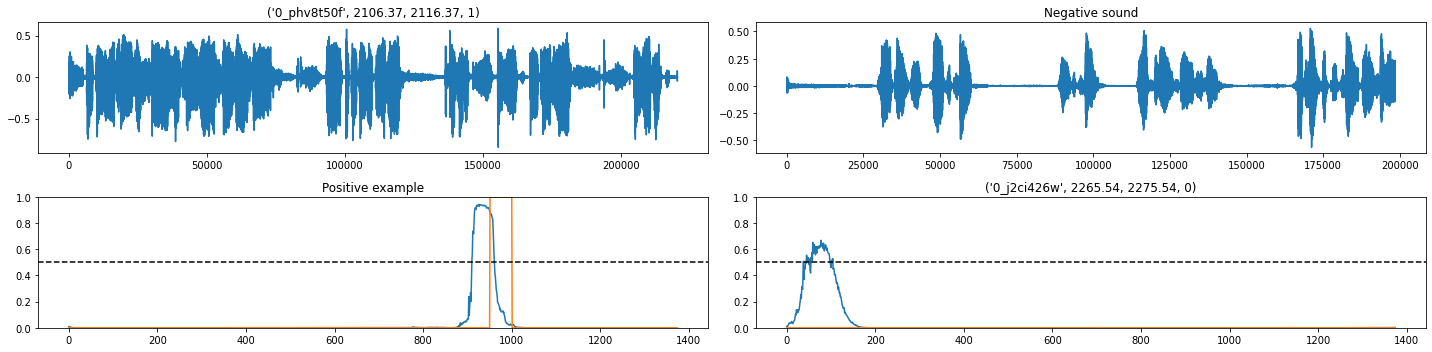

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_phv8t50f/format/url/protocol/https
From 00:35:06.37 to 00:35:16.37
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_j2ci426w/format/url/protocol/https
From 00:37:45.54 to 00:37:55.54


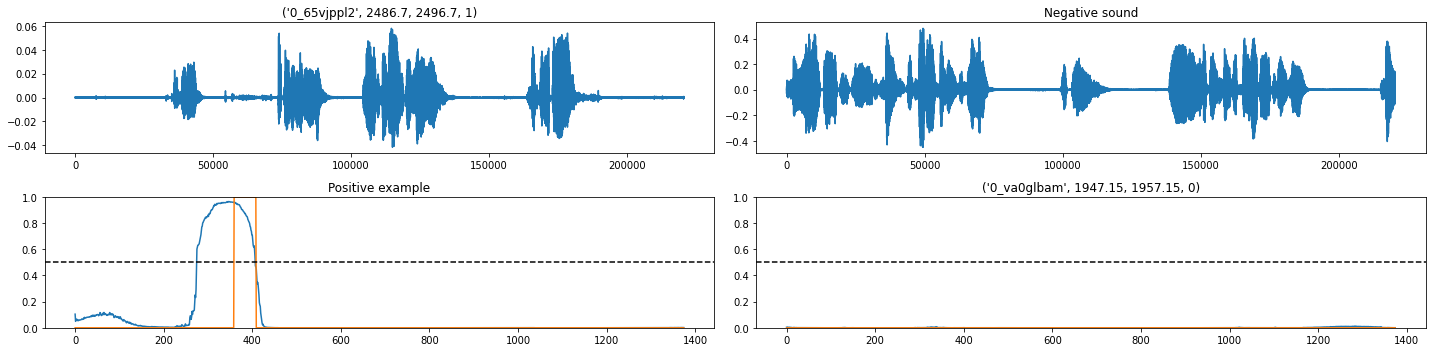

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_65vjppl2/format/url/protocol/https
From 00:41:26.70 to 00:41:36.70
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_va0glbam/format/url/protocol/https
From 00:32:27.15 to 00:32:37.15


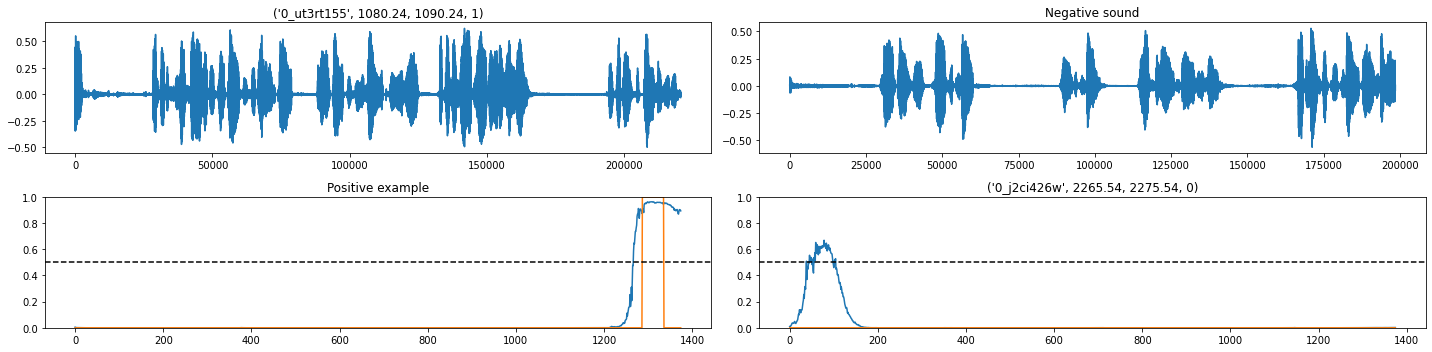

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_ut3rt155/format/url/protocol/https
From 00:18:00.24 to 00:18:10.24
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_j2ci426w/format/url/protocol/https
From 00:37:45.54 to 00:37:55.54


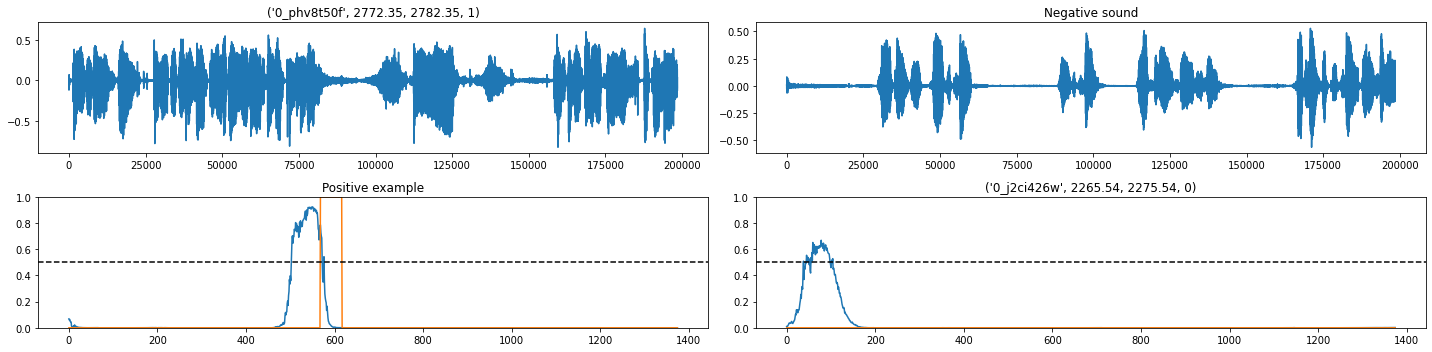

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_phv8t50f/format/url/protocol/https
From 00:46:12.35 to 00:46:22.35
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_j2ci426w/format/url/protocol/https
From 00:37:45.54 to 00:37:55.54


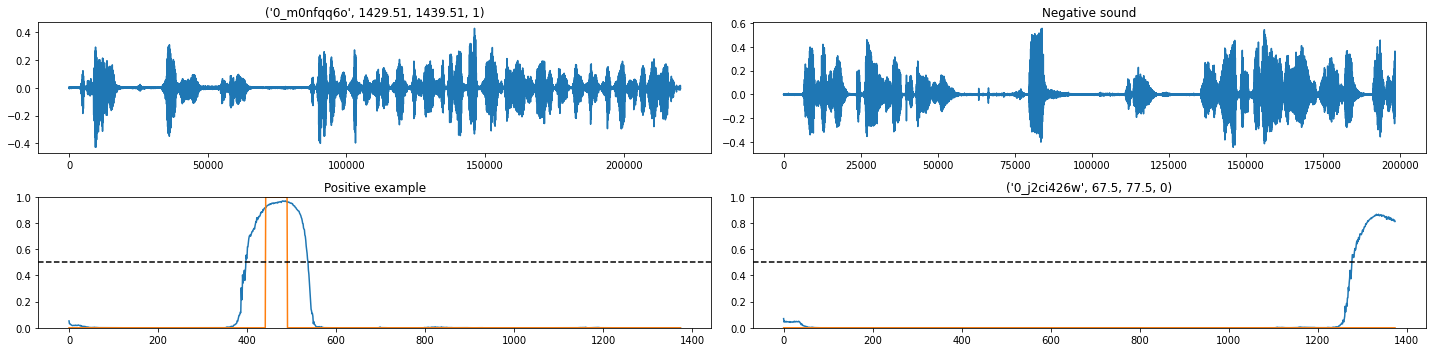

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_m0nfqq6o/format/url/protocol/https
From 00:23:49.51 to 00:23:59.51
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_j2ci426w/format/url/protocol/https
From 00:01:07.50 to 00:01:17.50


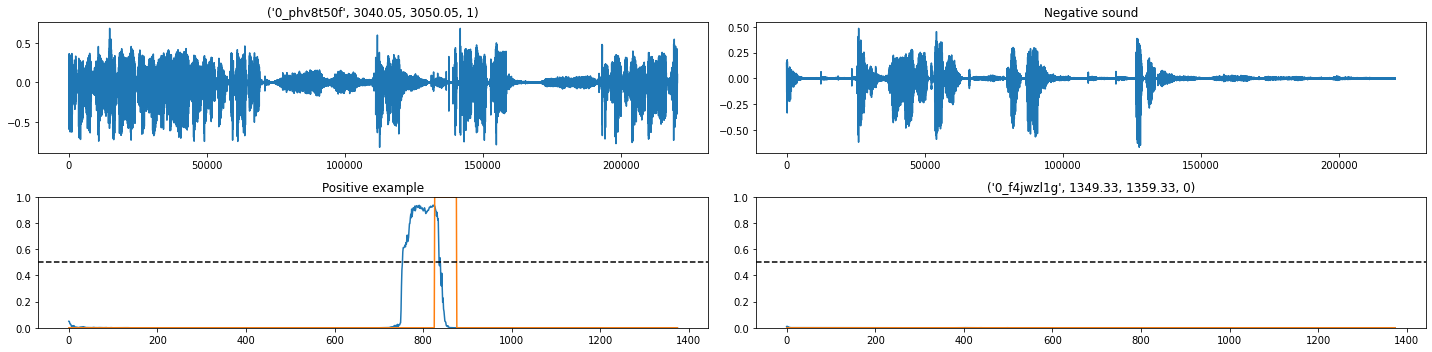

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_phv8t50f/format/url/protocol/https
From 00:50:40.05 to 00:50:50.05
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_f4jwzl1g/format/url/protocol/https
From 00:22:29.33 to 00:22:39.33


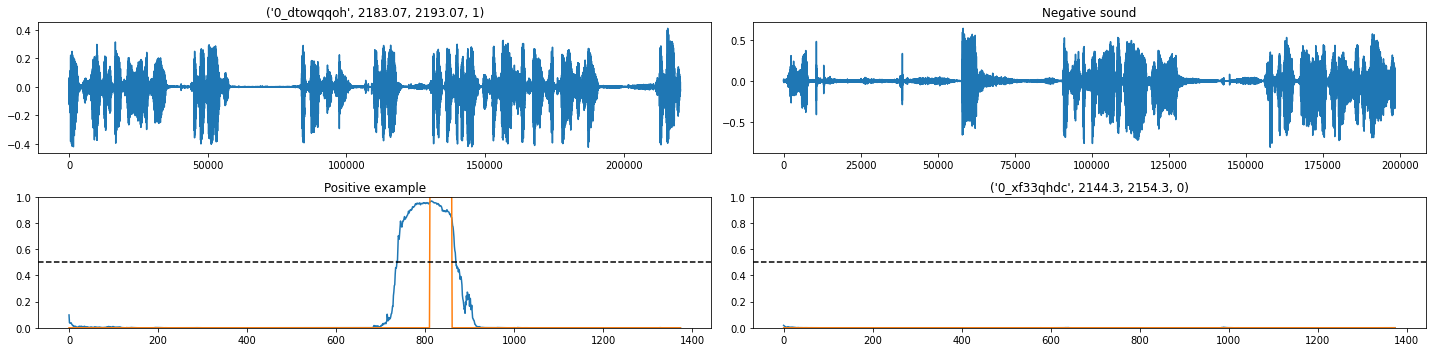

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_dtowqqoh/format/url/protocol/https
From 00:36:23.07 to 00:36:33.07
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_xf33qhdc/format/url/protocol/https
From 00:35:44.30 to 00:35:54.30


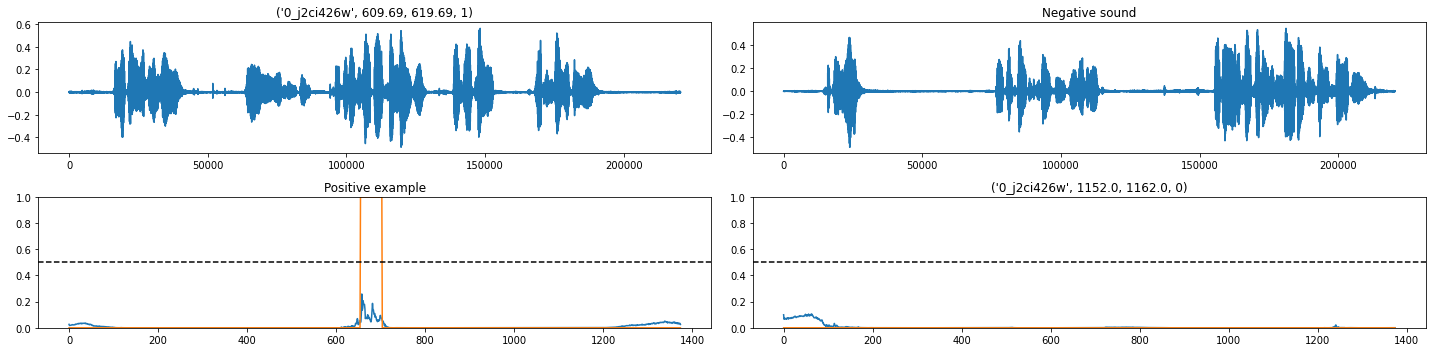

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_j2ci426w/format/url/protocol/https
From 00:10:09.69 to 00:10:19.69
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_j2ci426w/format/url/protocol/https
From 00:19:12.00 to 00:19:22.00


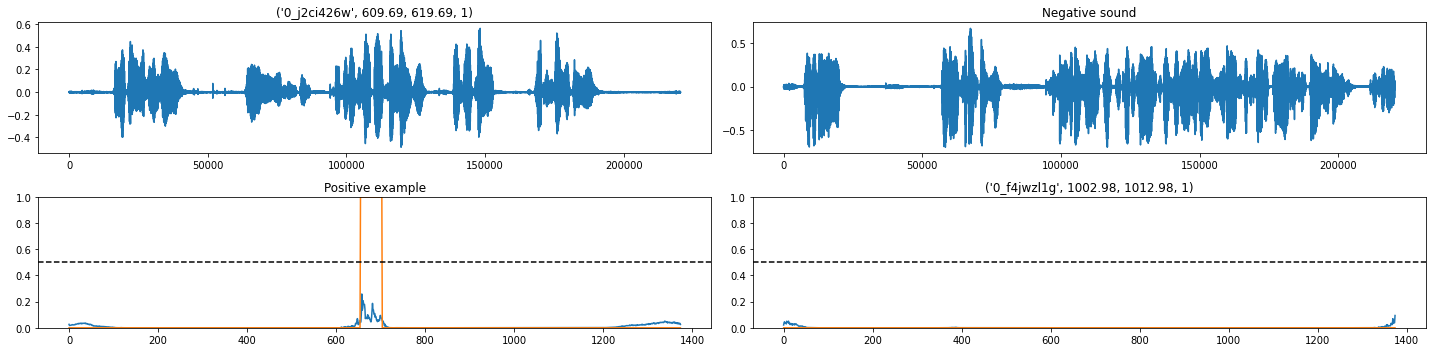

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_j2ci426w/format/url/protocol/https
From 00:10:09.69 to 00:10:19.69
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_f4jwzl1g/format/url/protocol/https
From 00:16:42.98 to 00:16:52.98


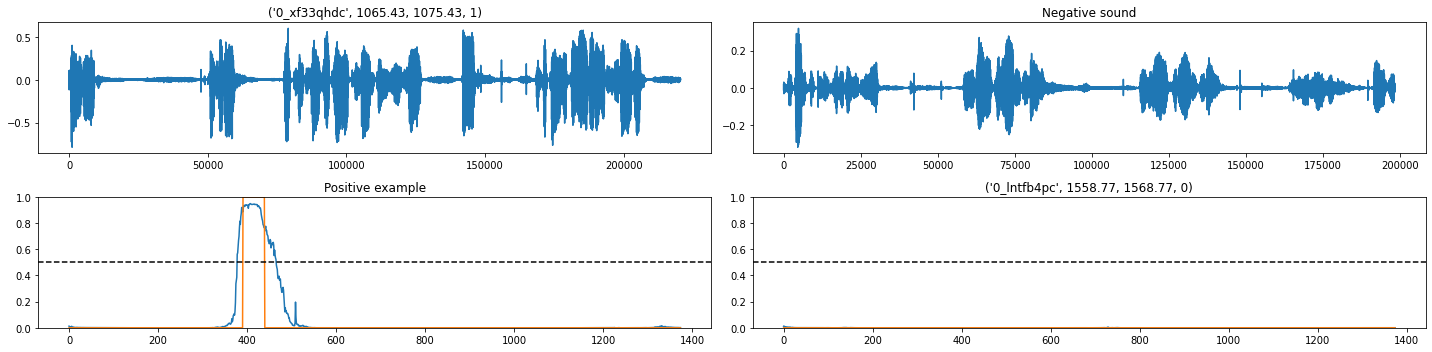

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_xf33qhdc/format/url/protocol/https
From 00:17:45.43 to 00:17:55.43
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_lntfb4pc/format/url/protocol/https
From 00:25:58.77 to 00:26:08.77


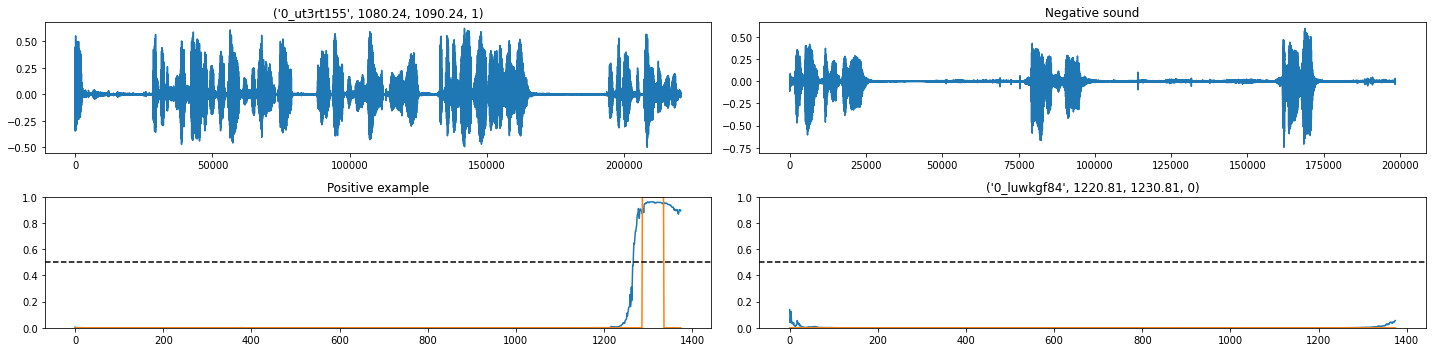

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_ut3rt155/format/url/protocol/https
From 00:18:00.24 to 00:18:10.24
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_luwkgf84/format/url/protocol/https
From 00:20:20.81 to 00:20:30.81


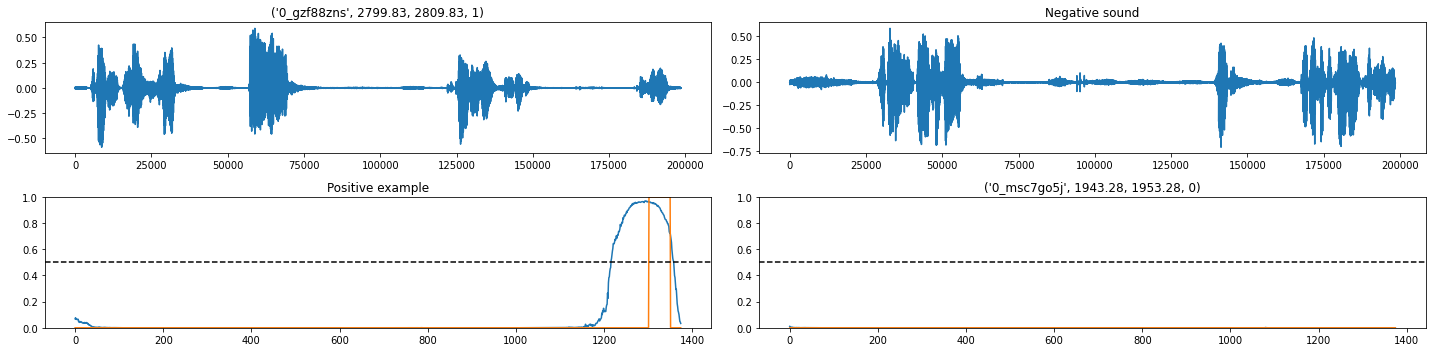

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_gzf88zns/format/url/protocol/https
From 00:46:39.83 to 00:46:49.83
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_msc7go5j/format/url/protocol/https
From 00:32:23.28 to 00:32:33.28


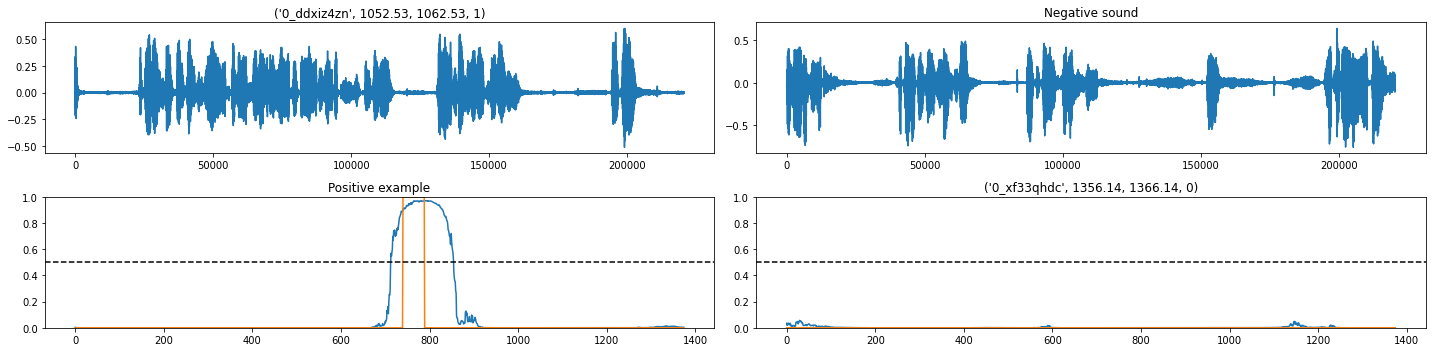

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_ddxiz4zn/format/url/protocol/https
From 00:17:32.53 to 00:17:42.53
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_xf33qhdc/format/url/protocol/https
From 00:22:36.14 to 00:22:46.14


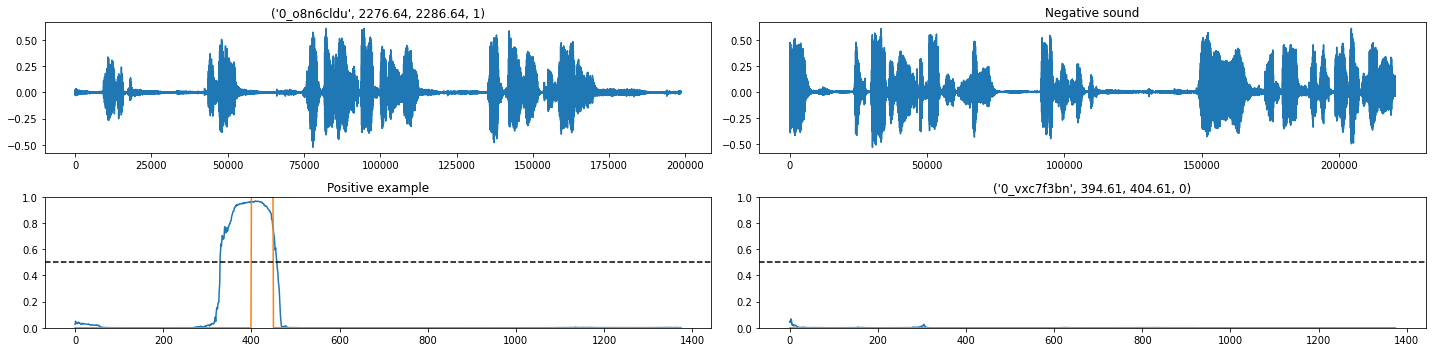

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_o8n6cldu/format/url/protocol/https
From 00:37:56.64 to 00:38:06.64
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_vxc7f3bn/format/url/protocol/https
From 00:06:34.61 to 00:06:44.61


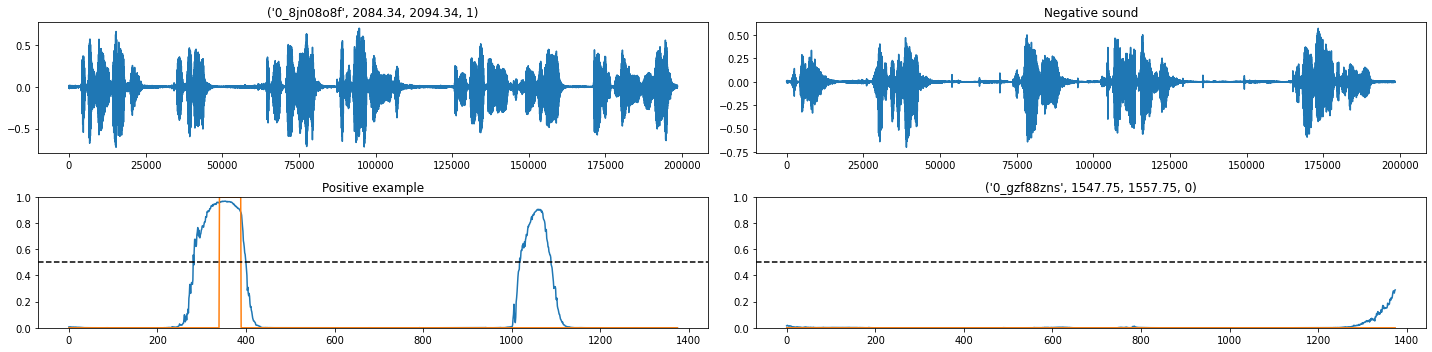

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_8jn08o8f/format/url/protocol/https
From 00:34:44.34 to 00:34:54.34
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_gzf88zns/format/url/protocol/https
From 00:25:47.75 to 00:25:57.75


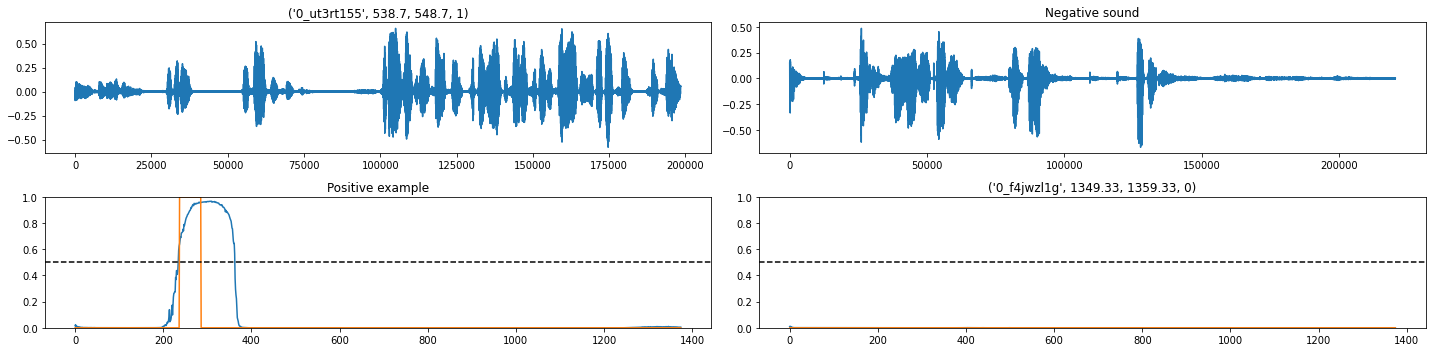

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_ut3rt155/format/url/protocol/https
From 00:08:58.70 to 00:09:08.70
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_f4jwzl1g/format/url/protocol/https
From 00:22:29.33 to 00:22:39.33


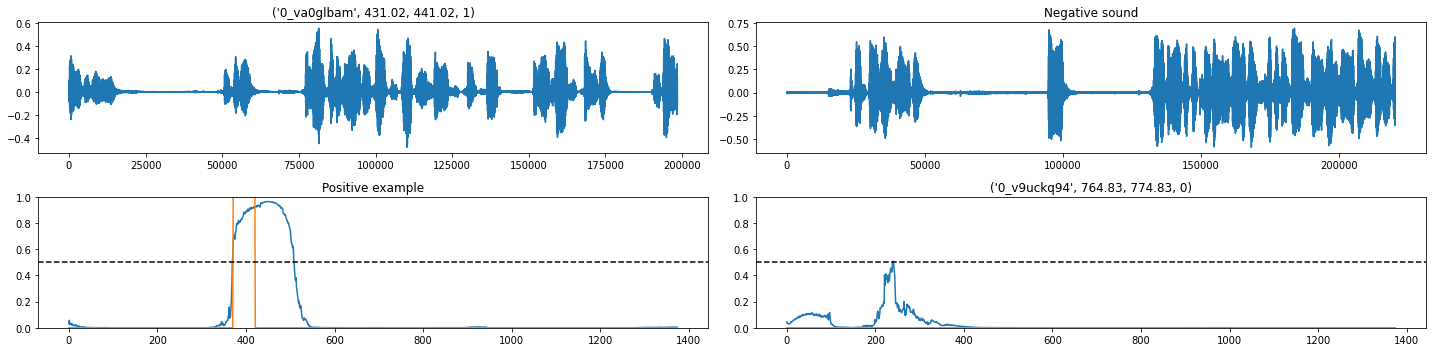

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_va0glbam/format/url/protocol/https
From 00:07:11.02 to 00:07:21.02
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_v9uckq94/format/url/protocol/https
From 00:12:44.83 to 00:12:54.83


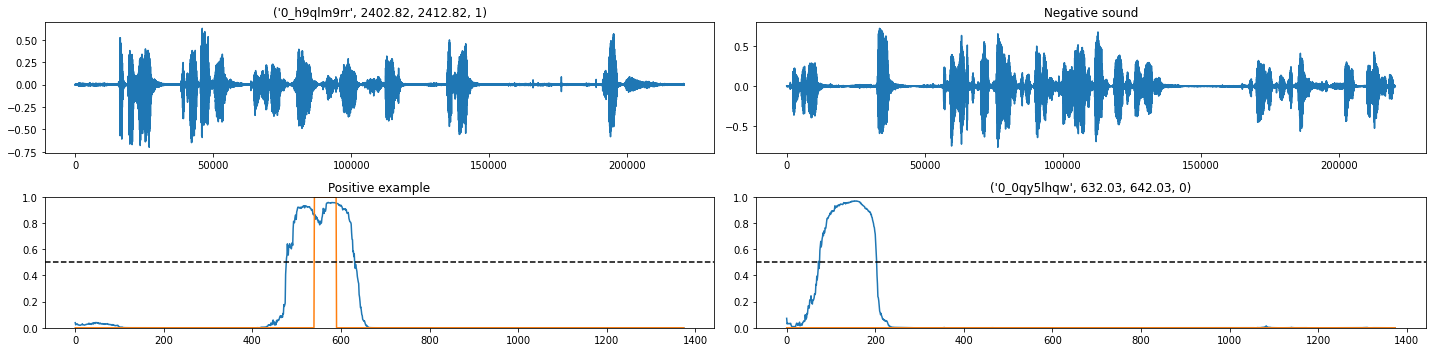

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_h9qlm9rr/format/url/protocol/https
From 00:40:02.82 to 00:40:12.82
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_0qy5lhqw/format/url/protocol/https
From 00:10:32.03 to 00:10:42.03


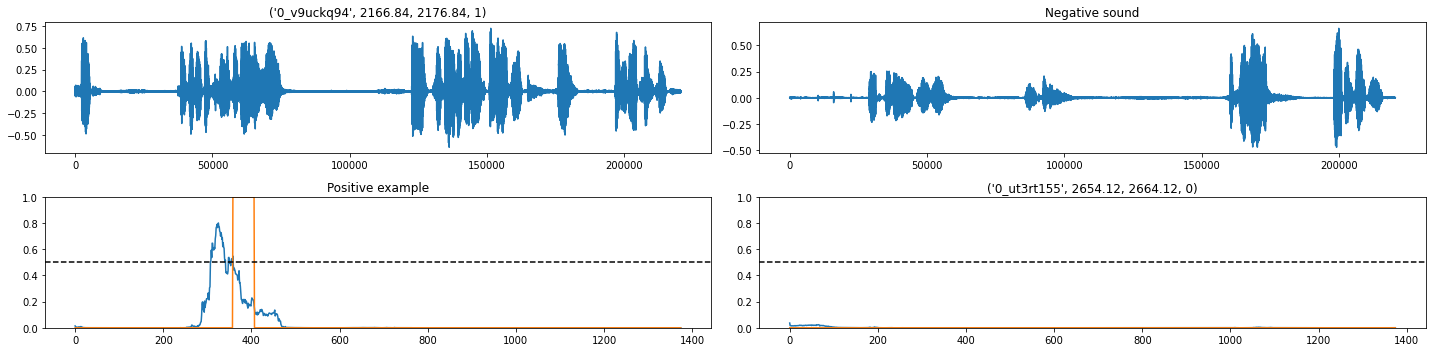

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_v9uckq94/format/url/protocol/https
From 00:36:06.84 to 00:36:16.84
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_ut3rt155/format/url/protocol/https
From 00:44:14.12 to 00:44:24.12


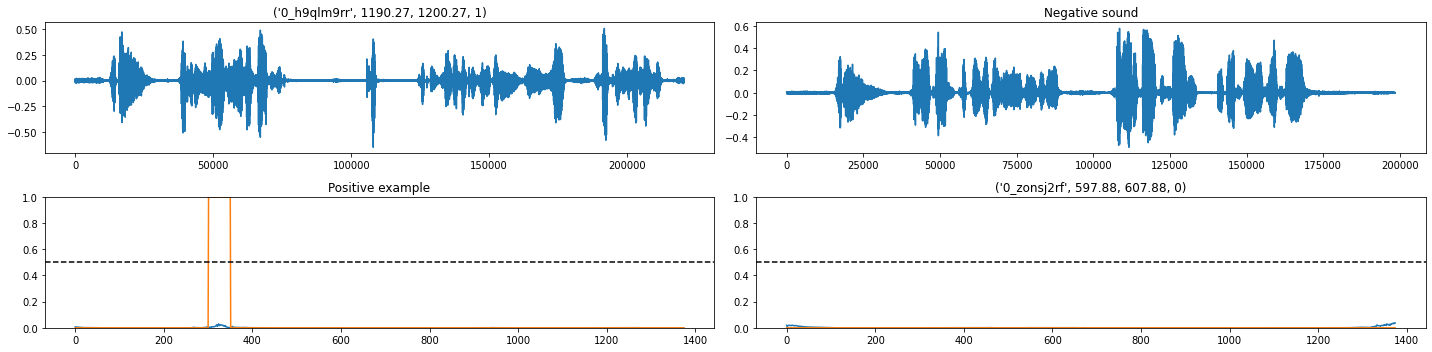

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_h9qlm9rr/format/url/protocol/https
From 00:19:50.27 to 00:20:00.27
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_zonsj2rf/format/url/protocol/https
From 00:09:57.88 to 00:10:07.88


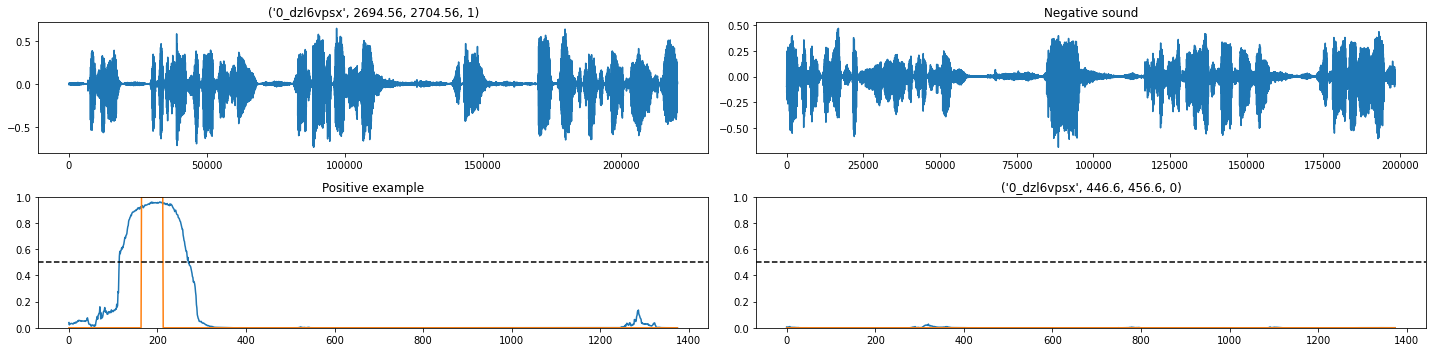

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_dzl6vpsx/format/url/protocol/https
From 00:44:54.56 to 00:45:04.56
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_dzl6vpsx/format/url/protocol/https
From 00:07:26.60 to 00:07:36.60


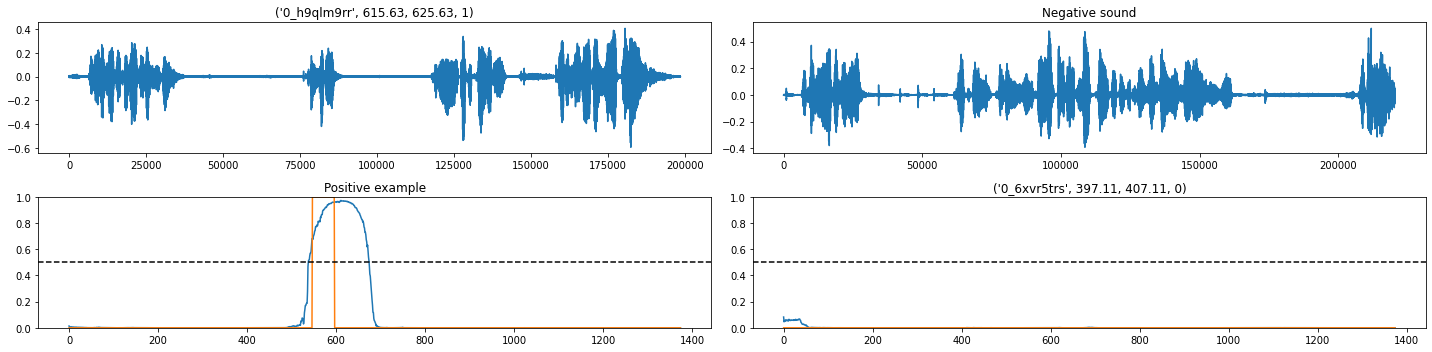

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_h9qlm9rr/format/url/protocol/https
From 00:10:15.63 to 00:10:25.63
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_6xvr5trs/format/url/protocol/https
From 00:06:37.11 to 00:06:47.11


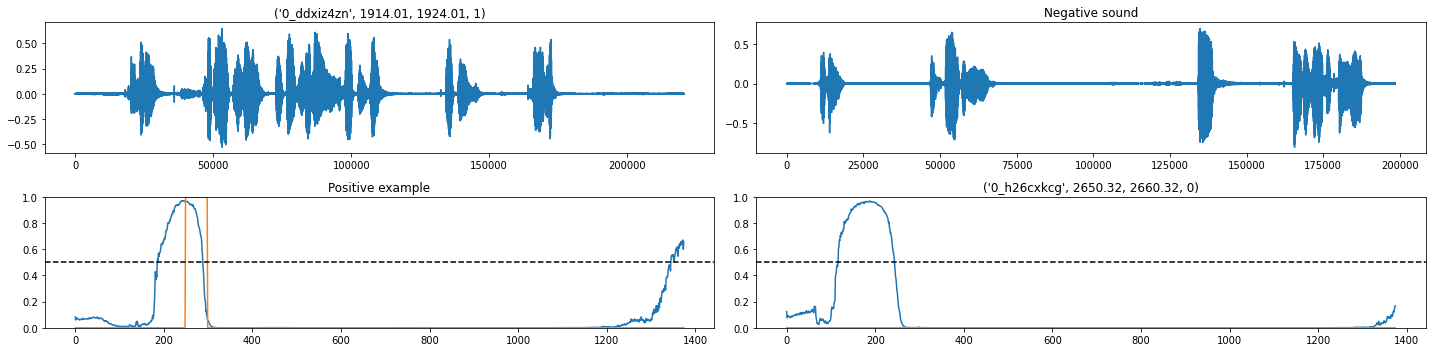

Positive example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_ddxiz4zn/format/url/protocol/https
From 00:31:54.01 to 00:32:04.01
Negative example:
https://dchsou11xk84p.cloudfront.net/p/201/sp/20100/playManifest/entryId/0_h26cxkcg/format/url/protocol/https
From 00:44:10.32 to 00:44:20.32


In [8]:
for i in range(25):

    idx_positive = np.random.choice(torch.where(contains_catchphrase)[0])
    idx_negative = np.random.choice(torch.where(contains_catchphrase==0)[0])

    positive_path = path[idx_positive]
    negative_path = path[idx_negative]

    _, t1_pos, t2_pos, _ = wf.info_from_path(positive_path)
    _, t1_neg, t2_neg, _ = wf.info_from_path(negative_path)


    plt.figure(figsize=(20,5))

    plt.subplot(2,2,1)
    audio, sr = torchaudio.load(positive_path)
    plt.plot(audio.mean(axis=0))
    plt.title(wf.info_from_path(positive_path))

    plt.subplot(2,2,2)
    audio, sr = torchaudio.load(negative_path)
    plt.plot(audio.mean(axis=0))
    plt.title('Negative sound')

    plt.subplot(2,2,3)
    plt.title('Positive example')
    plt.plot(torch.sigmoid(outputs[idx_positive]).detach().cpu())
    plt.plot(targets[idx_positive].detach().cpu())
    plt.axhline(0.5, linestyle='--', color='black')
    plt.ylim([0, 1])

    plt.subplot(2,2,4)
    plt.title(wf.info_from_path(path[idx_negative]))
    plt.plot(torch.sigmoid(outputs[idx_negative]).detach().cpu())
    plt.plot(targets[idx_negative].detach().cpu())
    plt.axhline(0.5, linestyle='--', color='black')
    plt.ylim([0, 1])

    plt.tight_layout()
    plt.show()

    print('Positive example:')
    ID, t1, t2, _ = wf.info_from_path(path[idx_positive])
    print(bom1.stream_link(ID))
    print(f'From {bom1.seconds_to_timestamp(t1)} to {bom1.seconds_to_timestamp(t2)}')

    print('Negative example:')
    ID, t1, t2, _ = wf.info_from_path(path[idx_negative])
    print(bom1.stream_link(ID))
    print(f'From {bom1.seconds_to_timestamp(t1)} to {bom1.seconds_to_timestamp(t2)}')

# Evaluate an entire lecture

In [93]:
#Folder path which to evaluate on.
folderpath      = '/work3/s164419/01005WakeWordData/every50_1s_val_test/val'
files           = [x for x in os.listdir(folderpath) if x.endswith('.wav')]
ID_t1_t2_target = [wf.info_from_path(x) for x in files]

ID, t, target = [x[0] for x in ID_t1_t2_target], [np.mean(x[1:3]) for x in ID_t1_t2_target], [x[3] for x in ID_t1_t2_target]

val_df = pd.DataFrame({'ID' : ID, 't' : t, 'target' : target})

#Get durations for all of the lectures.
durations = wf.lecture_durations()

utterance_duration = 1
target_duration    = 0.36

In [94]:
df = pd.DataFrame(columns = list(val_df.columns) + ['p'])
for ID, grp in tqdm(val_df.groupby('ID')):
    grp = grp.copy()
    
    #Calculate the probability here.
    grp['p'] = 0
    
    with torch.no_grad():
       data = wf.load_data(f'/work3/s164419/01005WakeWordData/lectures/{ID}.wav', f = T.Spectrogram(hop_length=40), normalize=True, transforms=[wf.TransformMono()])
       _, _, x = data
       outputs = rnn(x.unsqueeze(0))
    
    #Calculate the probability and the corresponding timepoints for the RNN. 
    p = torch.sigmoid(outputs).squeeze(-1)
    t = np.linspace(0, durations[ID], len(p))
    
    #Shift the timestamps back to be able to compare it.
    t = t - (utterance_duration/2 + target_duration/2)
    
    #Here, we interpolate the shifted probability back.
    grp['p'] = np.interp(grp['t'].to_numpy(), t, p)
    
    #Append the probability to the total dataset.
    df = df.append(grp, ignore_index=True)

100%|███████████████████████████████████████████| 47/47 [52:36<00:00, 67.16s/it]


In [96]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

prec, recall, thresholds = precision_recall_curve(df['target'].to_numpy().astype(int), df['p'].to_numpy())

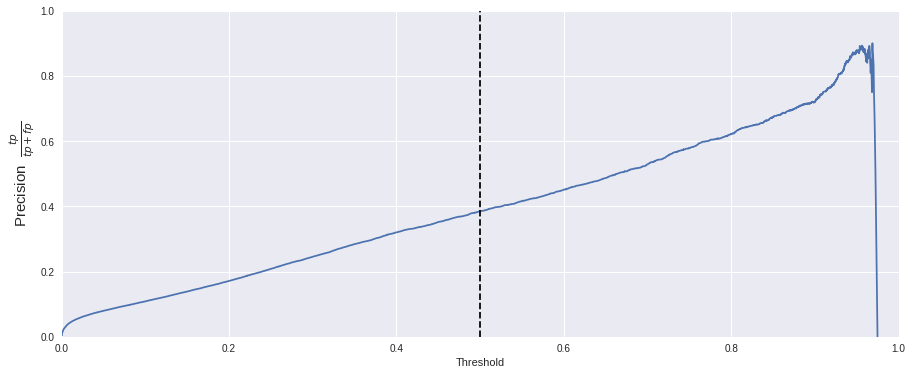

In [98]:
plt.style.use('seaborn')
plt.figure(figsize=(15,6))
plt.plot(thresholds, prec[:-1])
plt.xlabel('Threshold')
plt.ylabel('Precision  $\\frac{tp}{tp + fp}$', fontsize=15)
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

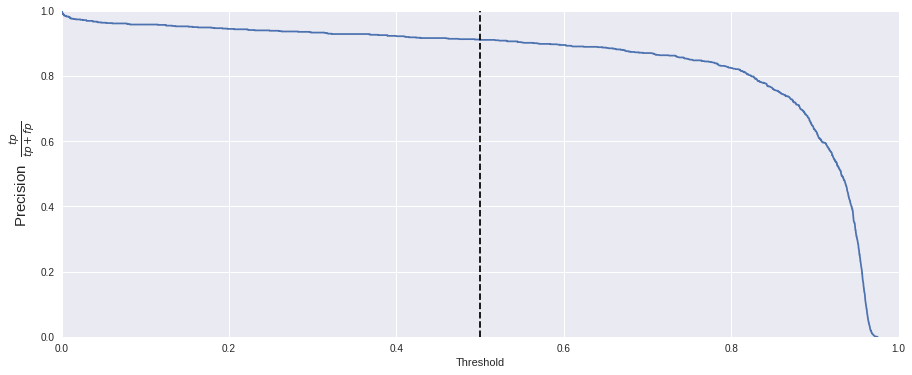

In [99]:
plt.style.use('seaborn')
plt.figure(figsize=(15,6))
plt.plot(thresholds, recall[:-1])
plt.xlabel('Threshold')
plt.ylabel('Precision  $\\frac{tp}{tp + fp}$', fontsize=15)
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()